## Moderate Resolution Imaging Spectroradiometer (MODIS) Burned Area 

#### Authors
- Michael Zargari, UC Santa Barbara (mzargari@ucsb.edu) 
- Dalila Lara, UC Santa Barbara (dalilalara@ucsb.edu) 
- Ruth Enriquez, UC Santa Barbara (rbe786@ucsb.edu) 

## Table of Contents

Include a summary of the various sections included in your notebook, so that users can easily skip to a section of interest. It's also good to include hyperlinks to the different sections, so that clicking on the heading sends one to that section directly. Examples are below; see also this handy guide to adding hyperlinks to Jupyter notebooks:
https://medium.illumidesk.com/jupyter-notebook-little-known-tricks-b0866a558017

The major sections you'll need for HW2 - and your group project - are shown below:

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

This notebook contains a walkthrough of our analysis of the FireCCI51: MODIS Fire_cci Burned Area Pixel Product, Version 5.1 dataset which contains data of burned areas over the continent of Australia from 2001 - 2020. We are conducting this analysis to assess the impact of the 2019 - 2020 Australian bushfire season, known as the Black Summer. The analysis conducted will provide visualizations of vegetation health through the tracking the change of NDVI.


<a id='overview'></a> 
### Dataset Description

This portion of the notebook should contain a summary description of your chosen environmental dataset. In a few paragraphs, discuss:

In this Jupyter Notebook we are looking at two datasets, our first one being FireCCI51: MODIS Fire_cci Burned Area Pixel Product, Version 5.1, and our second dataset being Actual Evapotranspiration for Australia (CMRSET Landsat V2.2).

- The creators of the dataset: NASA/NOAA/other government agency? Nonprofit? etc.

The creators of our first dataset include the European Space Agency (ESA) Climate Change Initiative (CCI) Programme, Fire ECV are the providers of the dataset MODIS Fire_cci Burned Area Pixel Product, Version 5.1 that we are using in our analysis. Although the satellite MODIS was launched by NASA in 2001, the ESA then made the dataset available via Google Earth Engine.

The second dataset is provided by TERN Landscapes and CSIRO Land and Water. TERN stands for Terrestrial Ecosystem Research Network. TERN is an Austrailian Government NCRIS (National Collaborative Research Infrastructure Strategy) enabled project. CSIRO stands for Commonwealth Scientific and Industrial Research Organisation. CSIRO is an Australian Government corporate entity that conducts scientific research.

- Major characteristics of the dataset: global coverage? Spatial resolution? Temporal resolution? Creation date? 

The first dataset contains information on burned area on a monthly global ~250m spatial resolution. The dataset uses surface reflectance in the Near Infrared (NIR) band from the MODIS instrument onboard the Terra satellite launched by NASA, as well as active fire information from the same sensor of the Terra and Aqua satellites.

This dataset includes the estimated day of the first detection of the fire, the confidence level of that detection, and the land cover that has been burned for each pixel. In addition, an observation flag is provided to identify the pixels that were not processed due to the lack of valid observations or because they belong to a non-burnable land cover.

The second dataset contains information about accurate actual evapotranspirations otherwise known as AET or ETa. Scientist used the CSIRO MODIS Relfectance-based Scaling EvapoTranspiration or CMRSET algorithm to calculate ETa by combining data from five remotely sensed data at different spatial resolutions:
1. 500 m, MODIS, VIIRS
2. 30 m, Landsat
3. 20 m, Sentinel-2
<br> and temporal frequencies:<br>
4. Daily, MODIS, VIIRS
5. Multi-days, Landsat, Sentinel-2

- The file format(s) used to store the data: netCDF? CSV? Other?

The first dataset is in GeoTiff format ussing the CRS World Geodetic System (WGS84) and uses the Plate Carrée projection. 

The second dataset is...

- The source/archive you will be using to retrieve the data: Google Earth Engine? Agency data portal? Other API?
We are accessing both datasets via Google Earth Engine using the Earth Engine Snippet. 

- Any known issues with data quality that might be expected to impact the results
There are two issues that we noticed regarding the first dataset quality. First is that it was noted that there are pixels that could not be processed because of the lack of quality data or because the pixels show land that cannot be burned in the first place (i.e. water). Secondly, the data stops at the end of 2020. This hinders our ability to track land and vegetation recovery rates into 2022.

For our second dataset...


Include links to any external resources needed to access the data here, including either the location of files stored on an external server you've set up or the access URL for a pre-existing repository. You can also include any example images you find useful for motivating the choice of dataset (optional).

<a href="https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1#dois" >MODIS Fire_cci Burned Area Pixel Product, Version 5.1 </a>

<a href = "https://developers.google.com/earth-engine/datasets/catalog/TERN_AET_CMRSET_LANDSAT_V2_2"> Actual Evapotranspiration for Australia (CMRSET Landsat V2.2) </a>



<a id='io'></a> 
### Dataset Input/Output 

Next, provide code to read in the data necessary for your analysis. This should be in the following order:

1) Import all necessary packages (matplotlib, numpy, etc)

2) Set any parameters that will be needed during subsequent portions of the notebook. Typical examples of parameters include:
- names of any directories where data are stored
- ranges of years over which data are valid
- any thresholds or latitude/longitude ranges to be used later (e.g. dimensions of NINO3.4 region, threshold SSTA values for El Nino, etc.)

3) Read in the data! If the data files are very large, you may want to consider subsetting the portion of files to be read in (see examples of this during notebooks provided in Weeks 7 and 8).

Here is a good rule of thumb: It's good to aim for a relatively short amount of time needed to read in the data, since otherwise we'll be sitting around waiting for things to load for a long time. A  minute or two for data I/O is probably the max you'll want to target!

In [1]:
## Importing packages 
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from geemap import cartoee

In [2]:
## Authenticate and initialize GEE
#ee.Authenticate()
ee.Initialize()

In [3]:
## Reading in the burned area data
burned_area = ee.ImageCollection("ESA/CCI/FireCCI/5_1") 
burned_area

In [4]:
## Specifiying area of interest Australia
lon = 133.94366873677208
lat = -31.14574060196506

poi = ee.Geometry.Point(lon, lat)
scale = 100000 #scale in m
                #scalling up og 1000

<a id='display'></a> 
### Metadata Display and Basic Visualization

Next, provide some example commands to take a quick look at what is in your dataset. We've done some things along these lines in class by now, but you should include at least one of:

- Metadata display: commands to indicate a) which variables are included in the dataset and their names; b) coordinate information associated with the data variables; c) other important metadata parameters (site names, etc); and d) any important information on missing data
- Basic visualization: a "quick and dirty" plot showing generally what the data look like. Depending on your dataset, this could be either a time series or a map (no fancy coordinate reference system/projection needed yet).

In [5]:
#Exploring the data 
#pulling test img 
test = burned_area.first()
#pulling info for test image (columns)
bands=test.bandNames()
str(bands.getInfo())

"['BurnDate', 'ConfidenceLevel', 'LandCover', 'ObservedFlag']"

In [6]:
## Exploring the data and seeing bands 

## Pulling Land Cover from data
region = burned_area.select("LandCover")
ts = region.getRegion(poi, scale).getInfo()

#Transforming the ts into a data frame 
df_australia = pd.DataFrame(ts)

headers=df_australia.loc[0] # Assign the first entry in the data frame to a variable called "headers"
# print(headers) # Look at headers

#new data frame with headers as column names 
df = pd.DataFrame(df_australia.values[1:], columns=headers)     # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers
## double checking that the headers are now columns 

# print(df)    

#now manipulating time column 
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df

,id,longitude,latitude,time,LandCover,datetime
0,2001_01_01,134.298135,-30.991877,978307200000,None,2001-01-01
1,2001_02_01,134.298135,-30.991877,980985600000,None,2001-02-01
2,2001_03_01,134.298135,-30.991877,983404800000,None,2001-03-01
3,2001_04_01,134.298135,-30.991877,986083200000,None,2001-04-01
4,2001_05_01,134.298135,-30.991877,988675200000,None,2001-05-01
...,...,...,...,...,...,...
235,2020_08_01,134.298135,-30.991877,1596240000000,None,2020-08-01
236,2020_09_01,134.298135,-30.991877,1598918400000,None,2020-09-01
237,2020_10_01,134.298135,-30.991877,1601510400000,None,2020-10-01
238,2020_11_01,134.298135,-30.991877,1604188800000,None,2020-11-01


In [7]:
## Making GEE maps of Australia LandCover before and after the 2019 Wildfire 

## Before Wildfire 


# Visualization parameters
visParams = {'bands': ['LandCover'],
             'min': 1,
             'max': 366,
             'palette': ['ff0000', 'fd4100', 'fb8200', 'f9c400', 'f2ff00', 'b6ff05',
    '7aff0a', '3eff0f', '02ff15', '00ff55', '00ff99', '00ffdd',
    '00ddff', '0098ff', '0052ff', '0210ff', '3a0dfb', '7209f6',
    'a905f1', 'e102ed', 'ff00cc', 'ff0089', 'ff0047', 'ff0004']
            }

# Define parameters for GEE base map
#lon = 133.94366873677208
#lat = -31.14574060196506

map_before_f = geemap.Map(center=[-31, 133], zoom=4)

# Command to extract all data over appropriate time, perform Land Cover avg
    #2015 - 2018 Avg of landcover 
t_before_f=burned_area.filter(ee.Filter.date('2015-01-01', '2018-12-30')).mean();

# Add layer to the basemap
map_before_f.addLayer(t_before_f, visParams)

# Draw map
map_before_f


Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [8]:
#Creating a legend using the band colors as defined in metadata
landcover_legend = {
"Cropland, rainfed" : "ffff64",
"Cropland, irrigated or post-flooding" : "aaf0f0",
"Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)" : "dcf064",
"Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)" : "c8c864",
"Tree cover, broadleaved, evergreen, closed to open (>15%)" : "6400",
"Tree cover, broadleaved, deciduous, closed to open (>15%)" : "00a000",
"Tree cover, needleleaved, evergreen, closed to open (>15%)" : "003c00",
"Tree cover, needleleaved, deciduous, closed to open (>15%)" : "285000",
"Tree cover, mixed leaf type (broadleaved and needleleaved)" : "788200",
"Mosaic tree and shrub (>50%) / herbaceous cover (<50%)" : "8ca000",
"Mosaic herbaceous cover (>50%) / tree and shrub (<50%)" : "be9600",
"Shrubland" : "966400",
"Grassland" : "ffb432",
"Lichens and mosses" : "ffdcd2",
"Sparse vegetation (tree, shrub, herbaceous cover) (<15%)" : "ffebaf",
"Tree cover, flooded, saline water" : "9678",
"Shrub or herbaceous cover, flooded, fresh/saline/brakish water" : "00dc82",
}

map_before_f.add_legend(legend_title="Landcover Legend", legend_dict=landcover_legend)


In [10]:
## Making GEE maps of Australia LandCover before and after the 2019 Wildfire 

## After Wildfire
    ## Australia Wildfire June 2019 - May 2020 
    
# Visualization parameters
visParams = {'bands': ['LandCover'],
             'min': 1,
             'max': 366,
             'palette': ['ff0000', 'fd4100', 'fb8200', 'f9c400', 'f2ff00', 'b6ff05',
    '7aff0a', '3eff0f', '02ff15', '00ff55', '00ff99', '00ffdd',
    '00ddff', '0098ff', '0052ff', '0210ff', '3a0dfb', '7209f6',
    'a905f1', 'e102ed', 'ff00cc', 'ff0089', 'ff0047', 'ff0004']
            }

# Define parameters for GEE base map
#lon = 133.94366873677208
#lat = -31.14574060196506

map_after_f = geemap.Map(center=[-31, 133], zoom=4)

# Command to extract all data over appropriate time, perform Land Cover avg
    #June 2019 - May 2020 Avg of landcover 
t_after_f=burned_area.filter(ee.Filter.date('2019-06-01', '2020-05-30')).mean();

# Add layer to the basemap
map_after_f.addLayer(t_after_f, visParams)

# Draw map
map_after_f

Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [11]:
#Creating a legend using the band colors as defined in metadata
landcover_legend = {
"Cropland, rainfed" : "ffff64",
"Cropland, irrigated or post-flooding" : "aaf0f0",
"Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) (<50%)" : "dcf064",
"Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%)" : "c8c864",
"Tree cover, broadleaved, evergreen, closed to open (>15%)" : "6400",
"Tree cover, broadleaved, deciduous, closed to open (>15%)" : "00a000",
"Tree cover, needleleaved, evergreen, closed to open (>15%)" : "003c00",
"Tree cover, needleleaved, deciduous, closed to open (>15%)" : "285000",
"Tree cover, mixed leaf type (broadleaved and needleleaved)" : "788200",
"Mosaic tree and shrub (>50%) / herbaceous cover (<50%)" : "8ca000",
"Mosaic herbaceous cover (>50%) / tree and shrub (<50%)" : "be9600",
"Shrubland" : "966400",
"Grassland" : "ffb432",
"Lichens and mosses" : "ffdcd2",
"Sparse vegetation (tree, shrub, herbaceous cover) (<15%)" : "ffebaf",
"Tree cover, flooded, saline water" : "9678",
"Shrub or herbaceous cover, flooded, fresh/saline/brakish water" : "00dc82",
}

map_after_f.add_legend(legend_title="Landcover Legend", legend_dict=landcover_legend)


<a id='usecases'></a> 
## Use Case Examples

This is the "meat" of the notebook, and what will take the majority of the time to present in class. This section should provide:
1) A plain-text summary (1-2 paragraphs) of the use case example you have chosen: include the target users and audience, and potential applicability. 

2) Markdown and code blocks demonstrating how one walks through the desired use case example. This should be similar to the labs we've done in class: you might want to demonstrate how to isolate a particularly interesting time period, then create an image showing a feature you're interested in, for example.

3) A discussion of the results and how they might be extended on further analysis. For example, if there are data quality issues which impact the results, you could discuss how these might be mitigated with additional information/analysis.

Just keep in mind, you'll have roughly 20 minutes for your full presentation, and that goes surprisingly quickly! Probably 2-3 diagnostics is the most you'll be able to get through (you could try practicing with your group members to get a sense of timing).


In [12]:
## Reading in Evapotranspiration for Australia
et = ee.ImageCollection("TERN/AET/CMRSET_LANDSAT_V2_2")
et

In [13]:
#Exploring the data for et
#pulling test img 
test_et = et.first()

#pulling info for test image (columns)
et_bands = test_et.bandNames()
str(et_bands.getInfo())

"['ETa', 'pixel_qa']"

In [14]:
## Exploring the data and seeing bands 

## Pulling Land Cover from data
et_region = et.select("ETa")
et_ts = et_region.getRegion(poi, scale).getInfo()

#Transforming the et_ts into a data frame 
et_df_australia = pd.DataFrame(et_ts)

et_headers = et_df_australia.loc[0] # Assign the first entry in the data frame to a variable called "headers"
print(et_headers) # Look at headers

# new data frame with headers as column names 
et_df = pd.DataFrame(et_df_australia.values[1:], columns = et_headers)     # Make a new data frame out of the old one, but assigning the names we just retrieved as actual column headers

## double checking that the headers are now columns 
print(et_df)    

#now manipulating time column 
et_df['date'] = pd.to_datetime(et_df['id'], format = "%Y_%d_%m")
et_df

0           id
1    longitude
2     latitude
3         time
4          ETa
Name: 0, dtype: object
0            id   longitude   latitude           time       ETa
0    2000_02_01  134.298135 -30.991877   949363200000  0.673877
1    2000_03_01  134.298135 -30.991877   951868800000  0.540017
2    2000_04_01  134.298135 -30.991877   954547200000  0.571822
3    2000_05_01  134.298135 -30.991877   957139200000  0.364262
4    2000_06_01  134.298135 -30.991877   959817600000  0.255632
..          ...         ...        ...            ...       ...
266  2022_04_01  134.298135 -30.991877  1648771200000  0.501027
267  2022_05_01  134.298135 -30.991877  1651363200000  0.407171
268  2022_06_01  134.298135 -30.991877  1654041600000  0.316519
269  2022_07_01  134.298135 -30.991877  1656633600000  0.316472
270  2022_08_01  134.298135 -30.991877  1659312000000   0.37151

[271 rows x 5 columns]


,id,longitude,latitude,time,ETa,date
0,2000_02_01,134.298135,-30.991877,949363200000,0.673877,2000-01-02
1,2000_03_01,134.298135,-30.991877,951868800000,0.540017,2000-01-03
2,2000_04_01,134.298135,-30.991877,954547200000,0.571822,2000-01-04
3,2000_05_01,134.298135,-30.991877,957139200000,0.364262,2000-01-05
4,2000_06_01,134.298135,-30.991877,959817600000,0.255632,2000-01-06
...,...,...,...,...,...,...
266,2022_04_01,134.298135,-30.991877,1648771200000,0.501027,2022-01-04
267,2022_05_01,134.298135,-30.991877,1651363200000,0.407171,2022-01-05
268,2022_06_01,134.298135,-30.991877,1654041600000,0.316519,2022-01-06
269,2022_07_01,134.298135,-30.991877,1656633600000,0.316472,2022-01-07


In [30]:
# et_df[(et_df['date'] > '2015-01-01') & (et_df['date'] < '2018-12-30')]

In [15]:
## Making evapotranspiration maps of Australia LandCover before and after the 2019 Wildfire 

## Before Wildfire 


# Visualization parameters
visParams2 = {'bands': ['ETa'],
             'min': 0,
             'max': 7,
             'palette': ['d7191c', 'fdae61', 'ffffbf', 'abd9e9', '2c7bb6']
            }

et_map_before_fire = geemap.Map(center=[-31, 133], zoom=4)

# Command to extract all data over appropriate time, perform Land Cover avg
    #2015 - 2018 Avg of landcover 
et_before_fire = et.filter(ee.Filter.date('2015-01-01', '2018-12-30'));

# Add layer to the basemap
et_map_before_fire.addLayer(et_before_fire, visParams2)

# Draw map
et_map_before_fire


Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [16]:
## Making GEE maps of Australia LandCover before and after the 2019 Wildfire 

## After Wildfire
    ## Australia Wildfire June 2019 - May 2020 
    
# Visualization parameters
visParams2 = {'bands': ['ETa'],
             'min': 0,
             'max': 7,
             'palette': ['d7191c', 'fdae61', 'ffffbf', 'abd9e9', '2c7bb6']
            }

et_map_after_fire = geemap.Map(center=[-31, 133], zoom=4)

# Command to extract all data over appropriate time, perform Land Cover avg
    #2015 - 2018 Avg of landcover 
et_after_fire = et.filter(ee.Filter.date('2019-06-01', '2020-05-30'));

# Add layer to the basemap
et_map_after_fire.addLayer(et_after_fire, visParams2)

# Draw map
et_map_after_fire


Map(center=[-31, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

(0, 0.5)

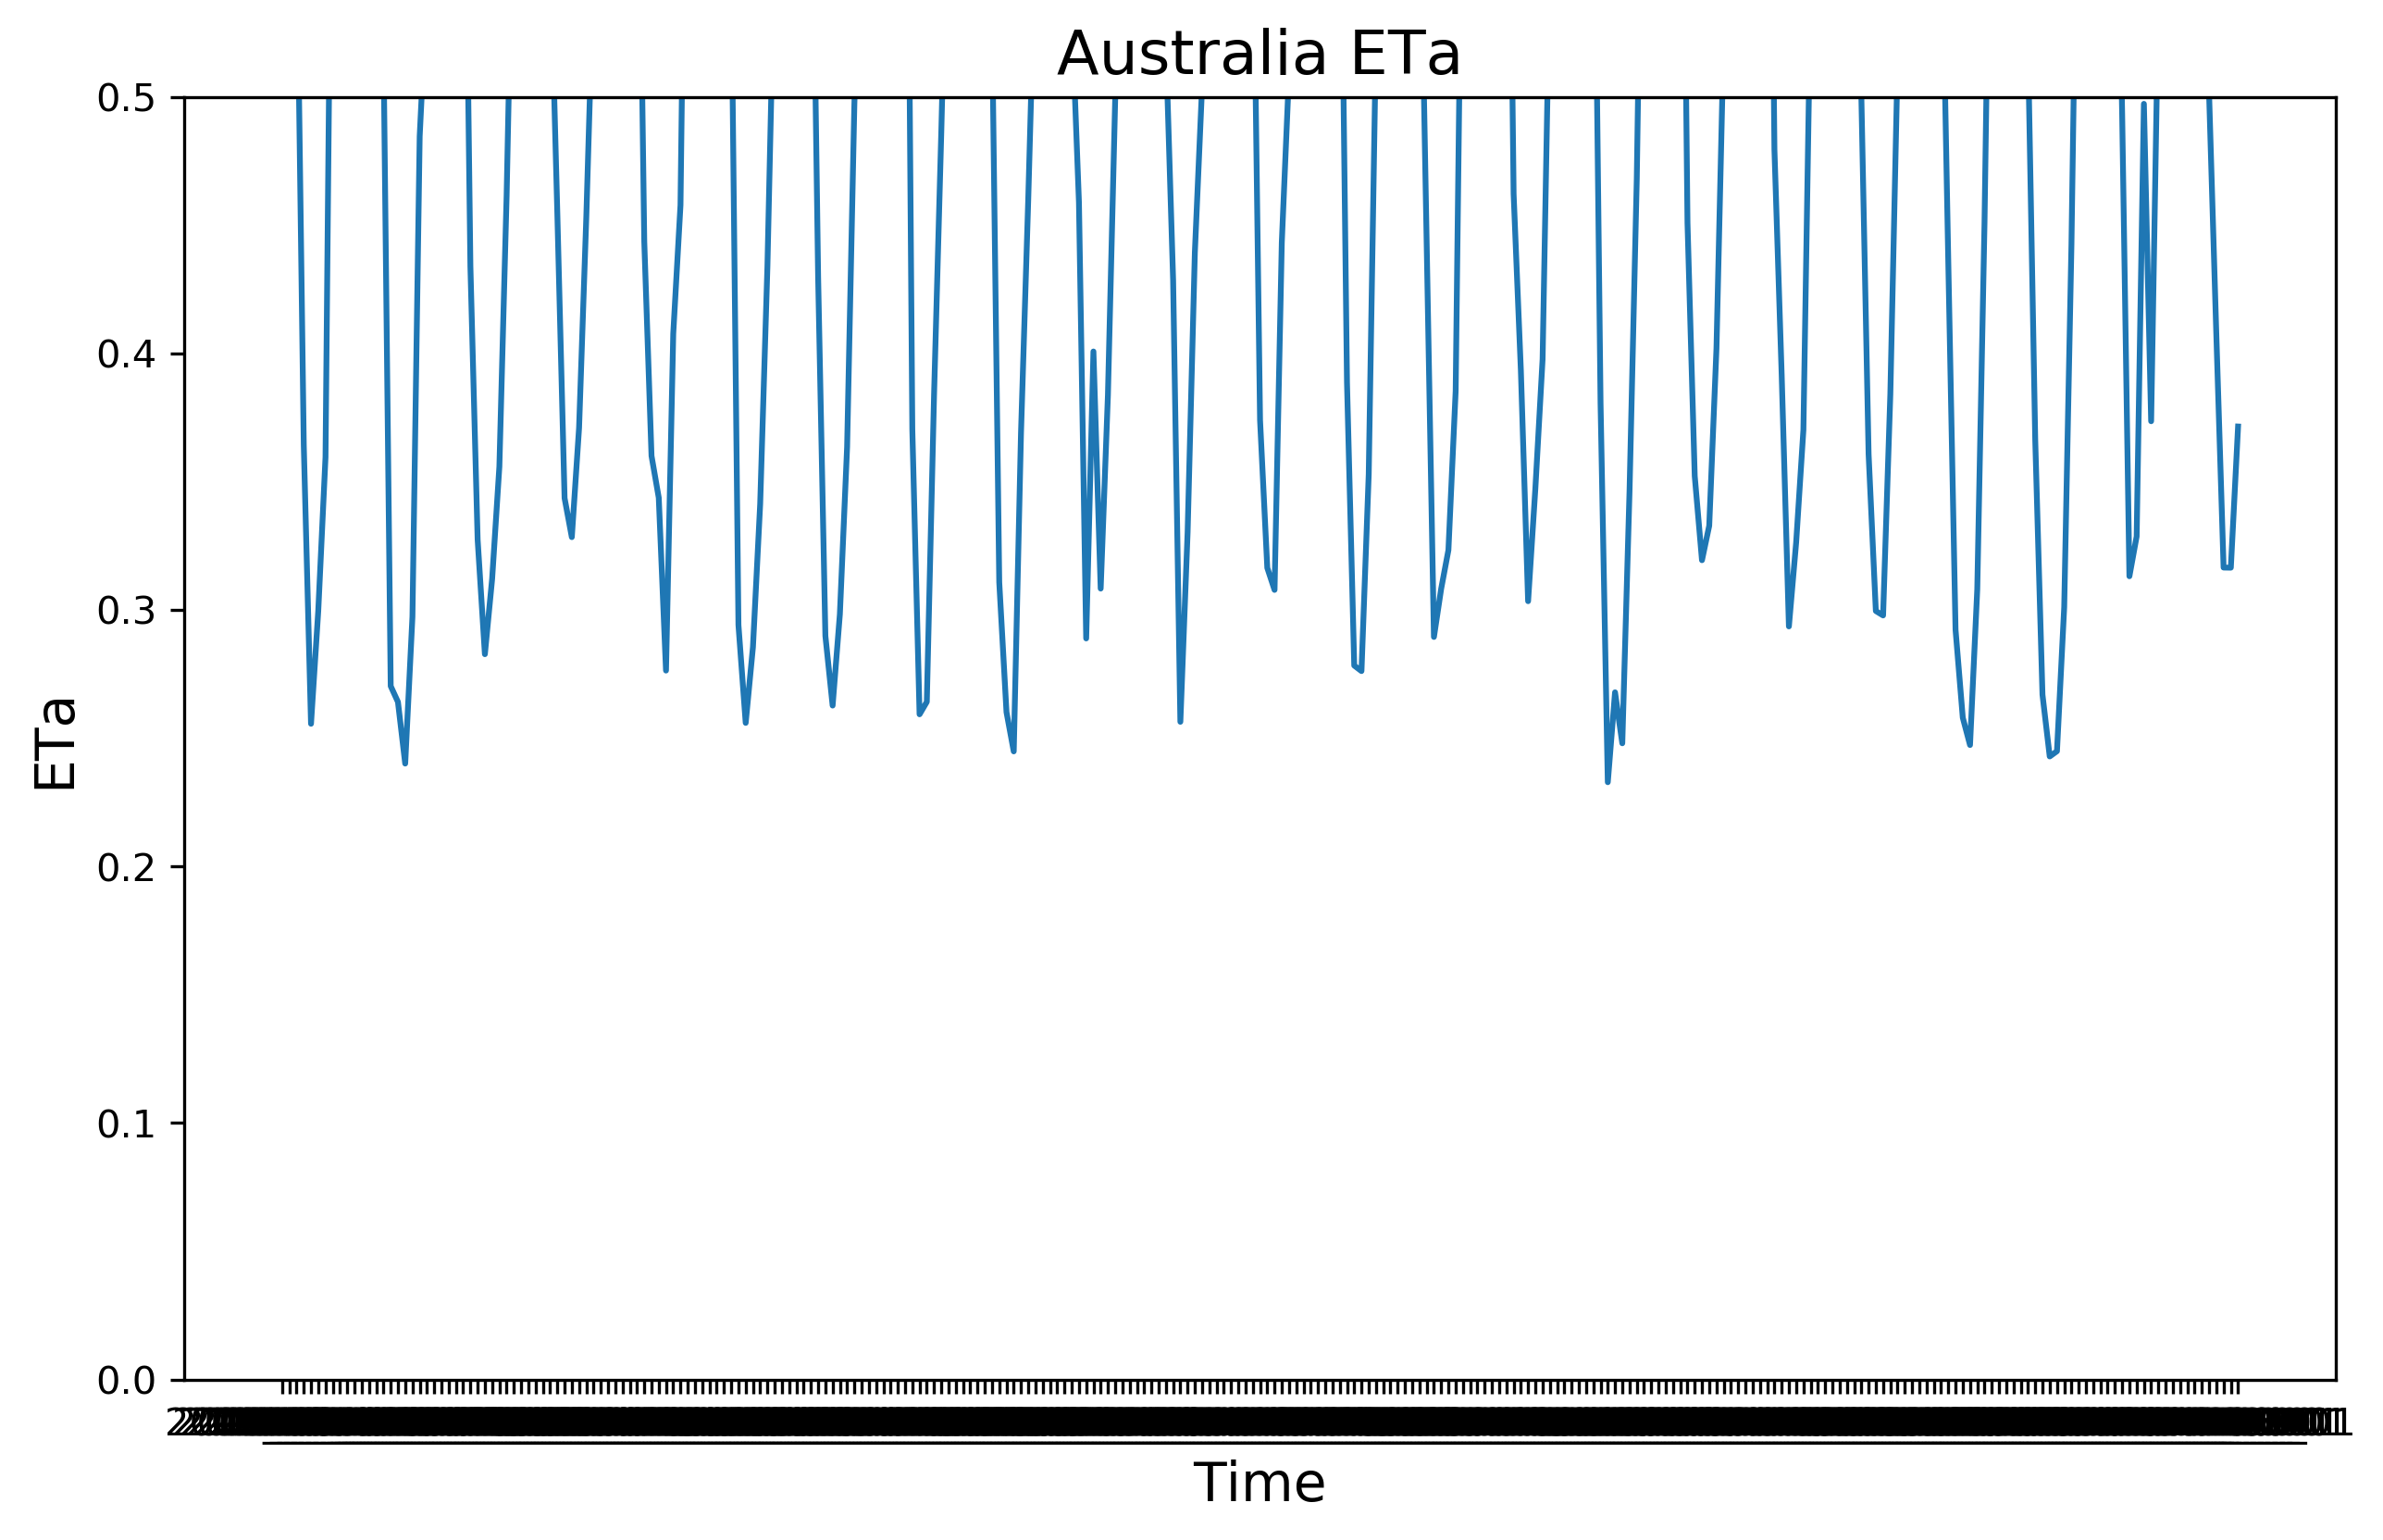

In [17]:
#plotting the et  
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(et_df['id'],et_df['ETa'])   # add data to the plot
plt.title('Australia ETa', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('ETa', fontsize=14)
plt.ylim(0, 0.5)

In [46]:
#map_before_f.ee.Feature(et_map_before_fire)
#et_map_after_fire.addLayer(map_after_f, visParams)

In [19]:
before_base_map = geemap.Map()
after_base_map = geemap.Map()

In [21]:
#Creating before fire base map of Australia
before_base_map.setCenter(133, -33, 4)

# Adding different layers over our Australia base map
before_base_map.addLayer(et_before_fire, visParams2, '2015 - 2018 Australia')
before_base_map.addLayer(t_before_f , visParams, 'Burned Area Before') 
before_base_map

Map(bottom=2691.0, center=[-33, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [22]:
#Creating after fire base map of Australia
after_base_map.setCenter(133, -33, 4)

# Adding different layers over our Australia base map
after_base_map.addLayer(et_after_fire, visParams2, '2019 - 2020  Australia')
after_base_map.addLayer(t_after_f , visParams, 'Burned Area After')

after_base_map

Map(center=[-33, 133], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

<a id='binder'></a> 
### Create Binder Environment

The last step is to create a Binder environment for your project, so that we don't have to spend time configuring everyone's environment each time we switch between group presentations. Instructions are below:

 - Assemble all of the data needed in your Github repo: Jupyter notebooks, a README file, and any datasets needed (these should be small, if included within the repo). Larger datasets should be stored on a separate server, and access codes included within the Jupyter notebook as discussed above. 
 
 - Create an _environment_ file: this is a text file which contains information on the packages needed in order to execute your code. The filename should be "environment.yml": an example that you can use for the proper syntax is included in this template repo. To determine which packages to include, you'll probably want to start by displaying the packages loaded in your environment: you can use the command `conda list -n [environment_name]` to get a list.
 
 More information on environment files can be found here:
 https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#

 - Create Binder. Use http://mybinder.org to create a  URL for your notebook Binder (you will need to enter your GitHub repo URL). You can also add a Launch Binder button directly to your GitHub repo, by including the following in your README.md:

```
launch with myBinder
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/<path to your repo>)
```

<a id='references'></a> 
### References

List relevant references. Here are some additional resources on creating professional, shareable notebooks you may find useful:

1. Notebook sharing guidelines from reproducible-science-curriculum: https://reproducible-science-curriculum.github.io/publication-RR-Jupyter/
2. Guide for developing shareable notebooks by Kevin Coakley, SDSC: https://github.com/kevincoakley/sharing-jupyter-notebooks/raw/master/Jupyter-Notebooks-Sharing-Recommendations.pdf
3. Guide for sharing notebooks by Andrea Zonca, SDSC: https://zonca.dev/2020/09/how-to-share-jupyter-notebooks.html
4. Jupyter Notebook Best Practices: https://towardsdatascience.com/jupyter-notebook-best-practices-f430a6ba8c69
5. Introduction to Jupyter templates nbextension: https://towardsdatascience.com/stop-copy-pasting-notebooks-embrace-jupyter-templates-6bd7b6c00b94  
    5.1. Table of Contents (Toc2) readthedocs: https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html  
    5.2. Steps to install toc2: https://stackoverflow.com/questions/23435723/installing-ipython-notebook-table-of-contents
6. Rule A, Birmingham A, Zuniga C, Altintas I, Huang SC, et al. (2019) Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks. PLOS Computational Biology 15(7): e1007007. https://doi.org/10.1371/journal.pcbi.1007007. Supplementary materials: example notebooks (https://github.com/jupyter-guide/ten-rules-jupyter) and tutorial (https://github.com/ISMB-ECCB-2019-Tutorial-AM4/reproducible-computational-workflows)
7. Languages supported by Jupyter kernels: https://github.com/jupyter/jupyter/wiki/Jupyter-kernels
8. EarthCube notebooks presented at EC Annual Meeting 2020: https://www.earthcube.org/notebooks
9. Manage your Python Virtual Environment with Conda: https://towardsdatascience.com/manage-your-python-virtual-environment-with-conda-a0d2934d5195
10. Venv - Creation of Virtual Environments: https://docs.python.org/3/library/venv.html